In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

import itertools

In [2]:
data = pd.read_csv('../../data/Sales/sales_train.csv')
print(data.shape)
data.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
item = pd.read_csv('../../data/Sales/items.csv')
print(item.shape)
item.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
category = pd.read_csv('../../data/Sales/item_categories.csv')
print(category.shape)
category.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
shop = pd.read_csv('../../data/Sales/shops.csv')
print(shop.shape)
shop.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


The dataset is from https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data
- ID: an Id that represents a (Shop, Item) tuple within the test set
- shop_id: unique identifier of a shop
- item_id: unique identifier of a product
- item_category_id: unique identifier of item category
- item_cnt_day: number of products sold. You are predicting a monthly amount of this measure
- item_price: current price of an item
- date: date in format dd/mm/yyyy
- date_block_num: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name: name of item
- shop_name: name of shop
- item_category_name: name of item category

In [6]:
full_data = pd.DataFrame(np.array(list(itertools.product(item['item_id'].unique(), shop['shop_id'].unique(), data['date_block_num'].unique()))), 
                          columns = ['item_id', 'shop_id', 'date_block_num'])
full_data.head()

,item_id,shop_id,date_block_num
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4


In [7]:
full_data = full_data.merge(data.groupby(['item_id', 'shop_id', 'date_block_num']).mean()['item_price'].reset_index(),
                              left_on = ['item_id', 'shop_id', 'date_block_num'],
                              right_on = ['item_id', 'shop_id', 'date_block_num'],
                              how = 'left')
full_data = full_data.merge(data.groupby(['item_id', 'shop_id', 'date_block_num']).sum()['item_cnt_day'].reset_index(),
                              left_on = ['item_id', 'shop_id', 'date_block_num'],
                              right_on = ['item_id', 'shop_id', 'date_block_num'],
                              how = 'left')
full_data.head()

,item_id,shop_id,date_block_num,item_price,item_cnt_day
0,0,0,0,NaN,NaN
1,0,0,1,NaN,NaN
2,0,0,2,NaN,NaN
3,0,0,3,NaN,NaN
4,0,0,4,NaN,NaN


In [8]:
full_data = full_data.rename(columns = {'item_cnt_day': 'item_cnt_month'})
full_data['item_cnt_month'] = full_data.fillna(0)
full_data.head()

,item_id,shop_id,date_block_num,item_price,item_cnt_month
0,0,0,0,NaN,0.0
1,0,0,1,NaN,0.0
2,0,0,2,NaN,0.0
3,0,0,3,NaN,0.0
4,0,0,4,NaN,0.0


In [12]:
full_data['month'] = [(x%12 + 1) for x in full_data['date_block_num']]
full_data['year'] = [(x//12 + 1) for x in full_data['date_block_num']]
full_data['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                       'Summer' if (x == 6 or x == 7 or x == 8) else
                       'Autumn' if (x == 9 or x == 10 or x == 11) else
                       'Winter' for x in full_data['month']]
full_data.head()

,item_id,shop_id,date_block_num,item_price,item_cnt_month,month,year,season
0,0,0,0,NaN,0.0,1,1,Winter
1,0,0,1,NaN,0.0,2,1,Winter
2,0,0,2,NaN,0.0,3,1,Spring
3,0,0,3,NaN,0.0,4,1,Spring
4,0,0,4,NaN,0.0,5,1,Spring


In [ ]:
sns.factorplot(data = full_data, x = 'season', y = 'item_cnt_month')
plt.show()

C:\Users\anson\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


In [26]:
data_month.isna().sum()

shop_id           0
item_id           0
month             0
item_price        0
item_cnt_month    0
dtype: int64

In [23]:
data_month.describe()
# Usually 1 for item_cnt_day

,shop_id,item_id,item_price,item_cnt_month
count,1.396971e+06,1.396971e+06,1.396971e+06,1.396971e+06
mean,3.269555e+01,1.084648e+04,7.985076e+02,2.611512e+00
std,1.659560e+01,6.232465e+03,1.590232e+03,1.205841e+01
min,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01
25%,2.100000e+01,5.271000e+03,1.990000e+02,1.000000e+00
50%,3.100000e+01,1.077200e+04,3.980000e+02,1.000000e+00
75%,4.700000e+01,1.614800e+04,8.658333e+02,2.000000e+00
max,5.900000e+01,2.216900e+04,3.079800e+05,2.514000e+03


In [28]:
sns.displot(data = data_month, x = 'item_cnt_month')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000243FD627378> (for post_execute):


KeyboardInterrupt: 

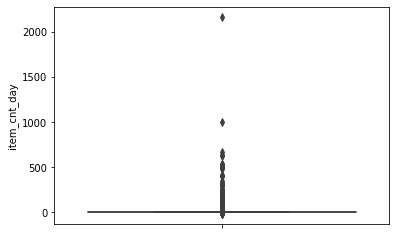

In [8]:
sns.boxplot(data = data_month, y = 'item_cnt_month')
plt.show()
# Very right-skewed.
# Even with negative value

In [9]:
data['item_cnt_day'].value_counts()

1.0      2629372
2.0       194201
3.0        47350
4.0        19685
5.0        10474
          ...   
179.0          1
187.0          1
194.0          1
195.0          1
508.0          1
Name: item_cnt_day, Length: 198, dtype: int64

In [15]:
data['item_cnt_day'].value_counts(normalize = True).head()
# Almsot 90% 1

1.0    0.895609
2.0    0.066148
3.0    0.016128
4.0    0.006705
5.0    0.003568
Name: item_cnt_day, dtype: float64

In [16]:
len(data[data['item_cnt_day'] < 0]) / len(data)
# Some of them are negative.

0.0025055784544777337